In [102]:
import numpy as np
from pydpmd.data import RigidBumpy, load
from pydpmd.plot import draw_particles_frame, create_animation, downsample
from correlation_functions import compute_msd, compute_shear_modulus, compute_rotational_msd, compute_pair_correlation_function, compute_vacf, compute_rotational_msd
from pydpmd.calc import run_binned, run_binned_ragged, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import re
from tqdm import tqdm
from scipy.optimize import minimize
import pandas as pd
def obj_func(b, x, y):
    return np.sum((x + b - y) ** 2)

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

In [103]:
overlap_df = pd.read_csv(os.path.join('/home/mmccraw/dev/data/09-27-25/finding-hard-particle-limit/', 'aggregated-data.csv'))
overlap_df = overlap_df[(overlap_df.temp < 5e-6)]

def get_max_phi(overlap_df, mu, nv, overlap_factor):
    df = overlap_df[np.isclose(overlap_df.nv, nv) & (np.isclose(overlap_df.mu, mu))]
    x = df.phi.values
    y = df.avg_dim_overlap.values
    order = np.argsort(x)
    x = x[order]
    y = y[order]
    mask = y < np.mean(y[:10]) * overlap_factor
    return np.max(x[mask])

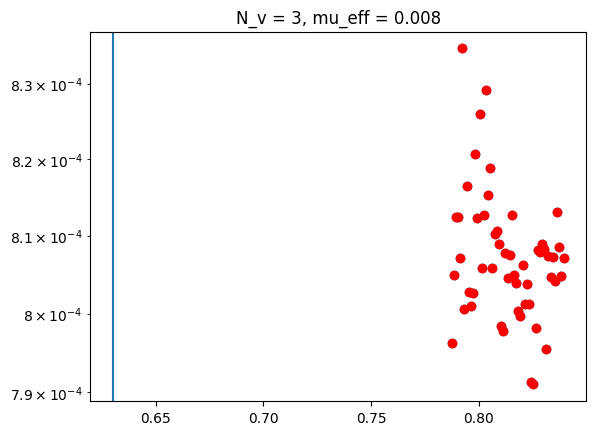

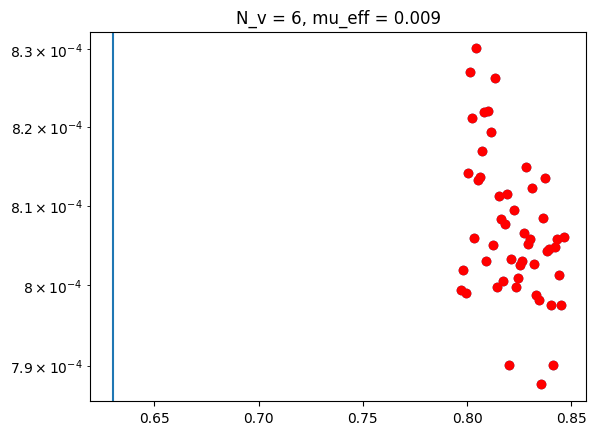

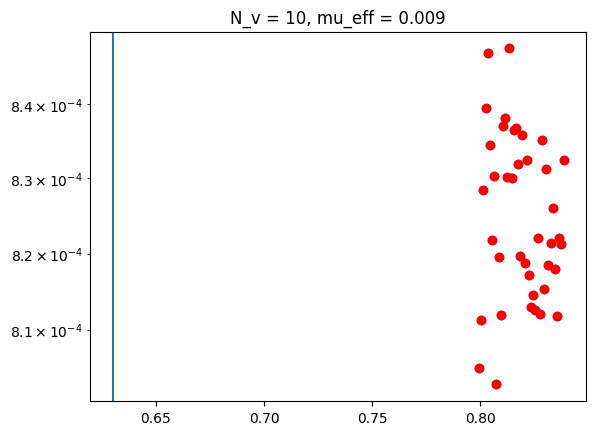

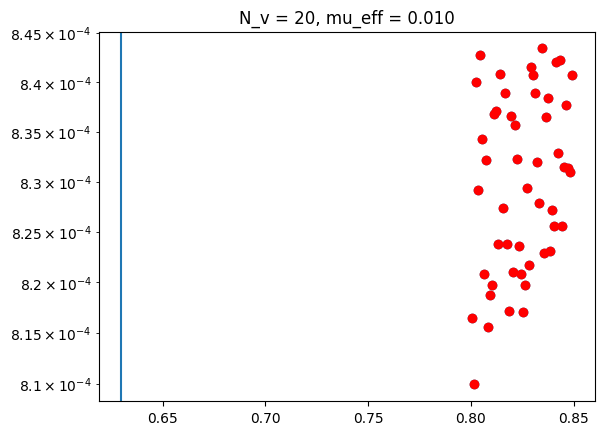

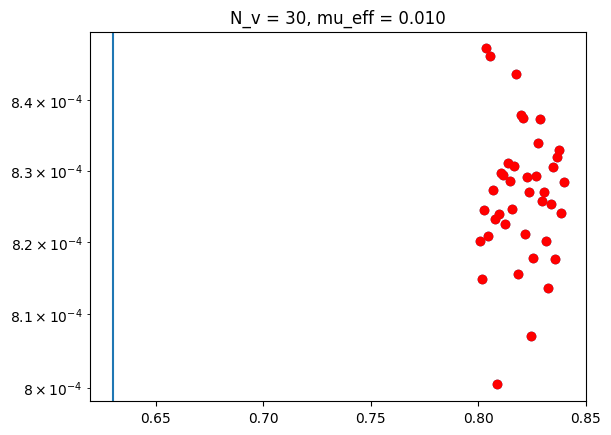

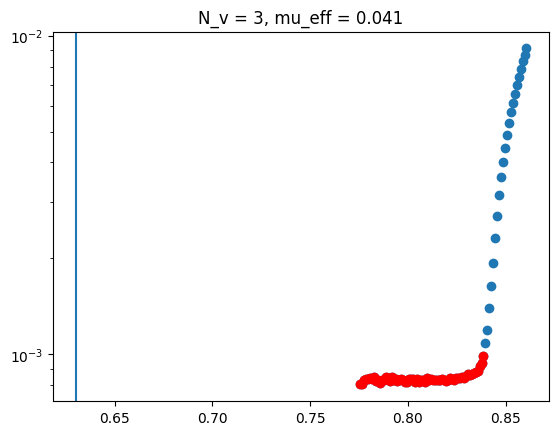

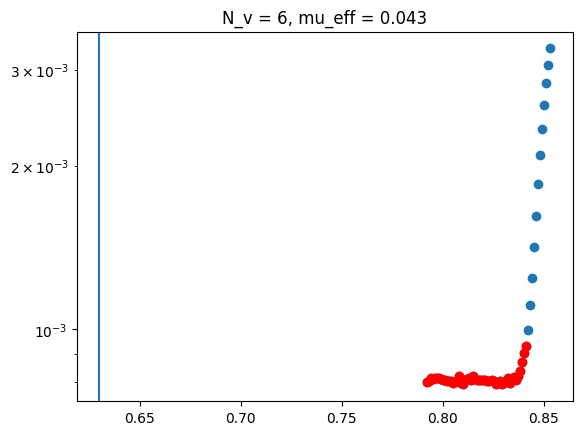

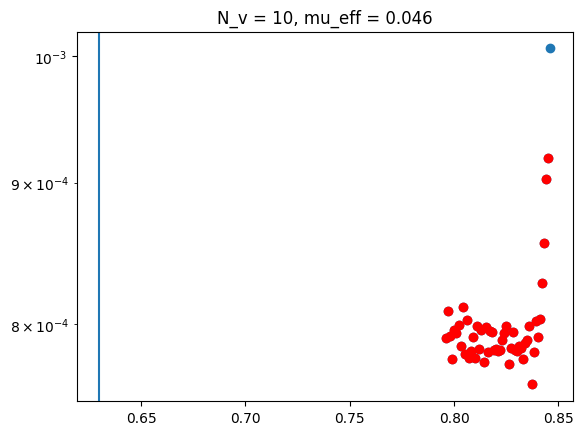

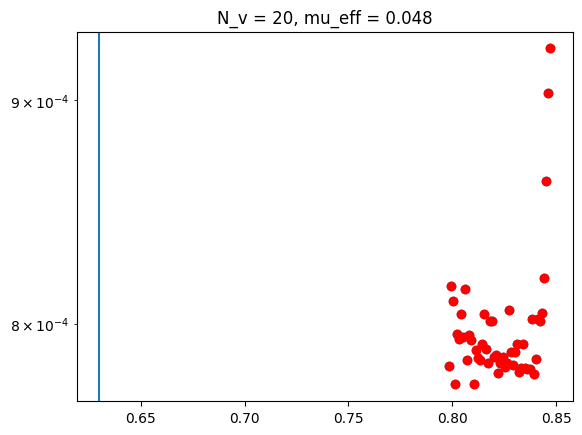

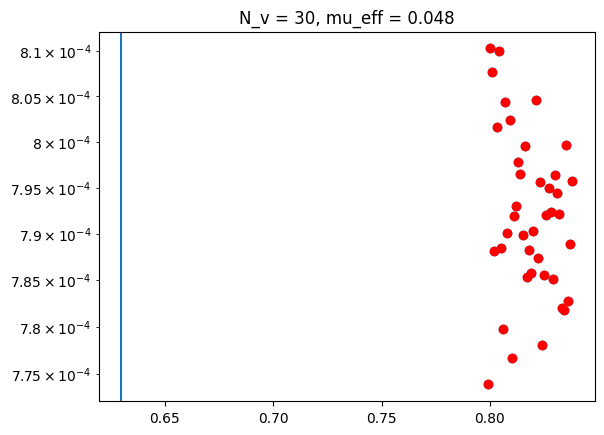

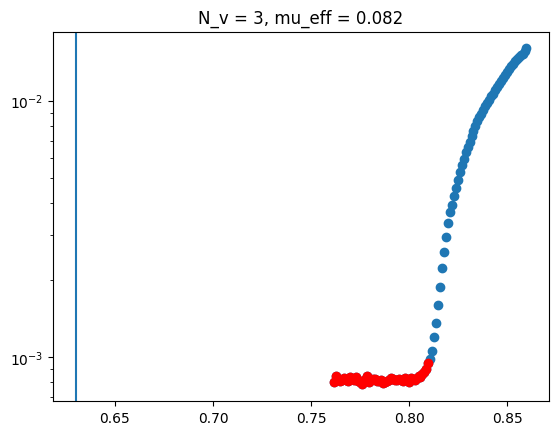

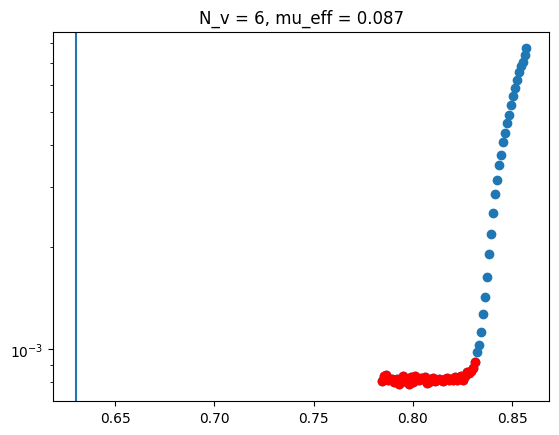

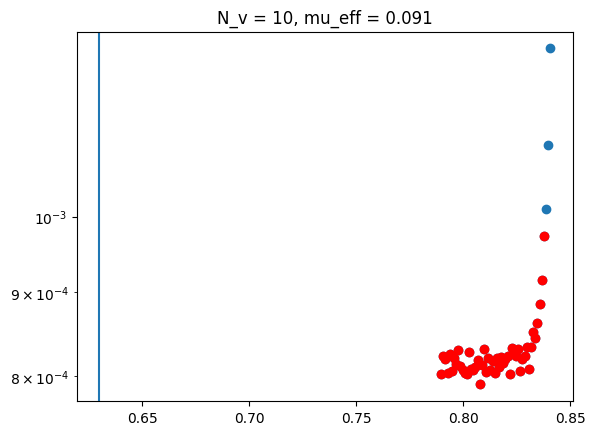

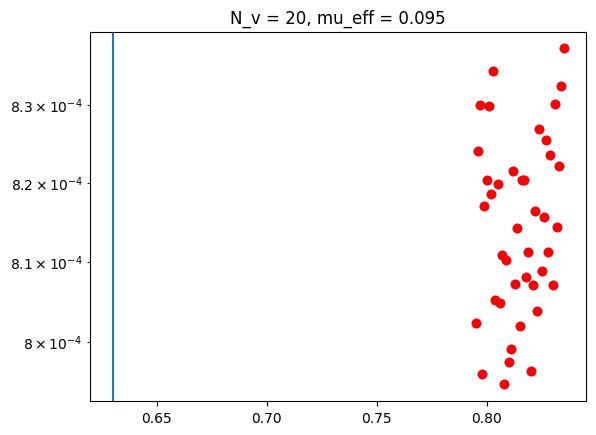

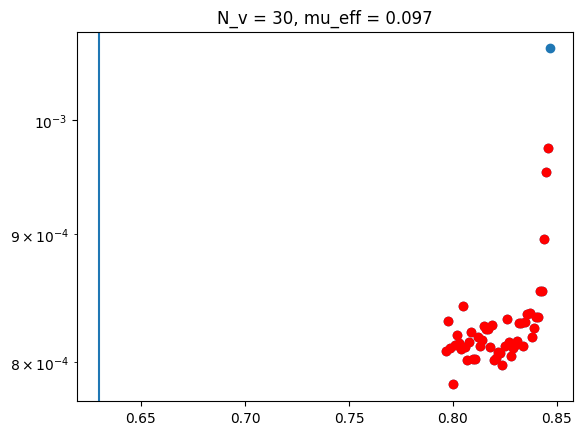

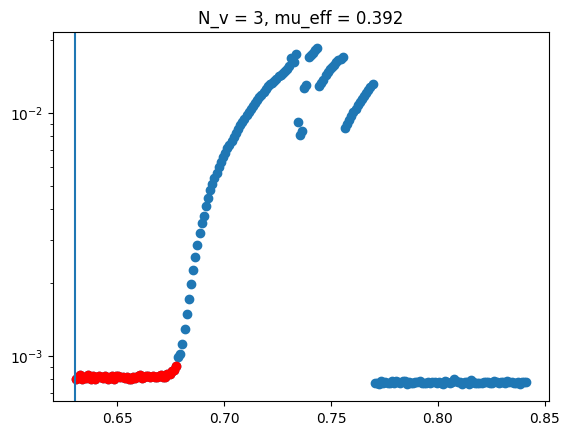

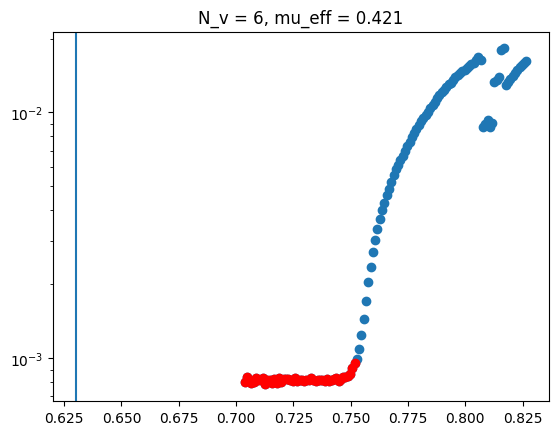

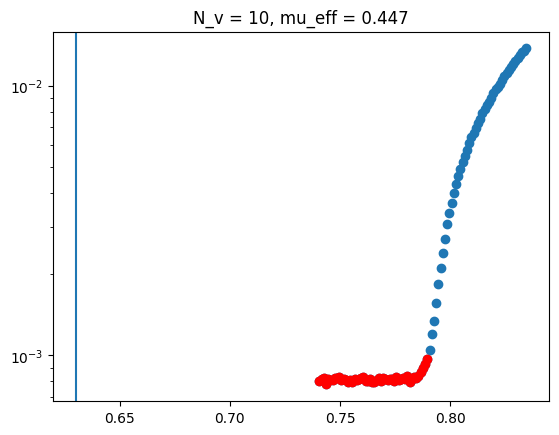

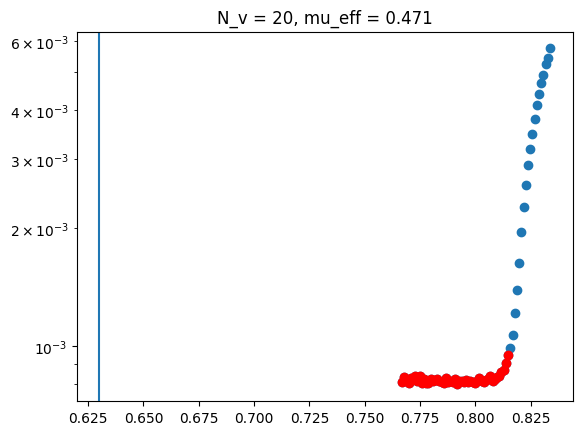

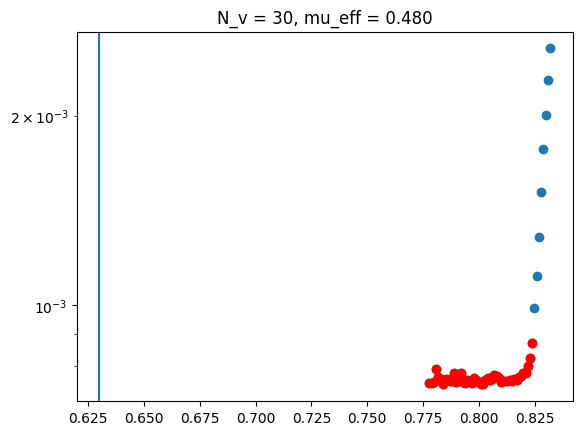

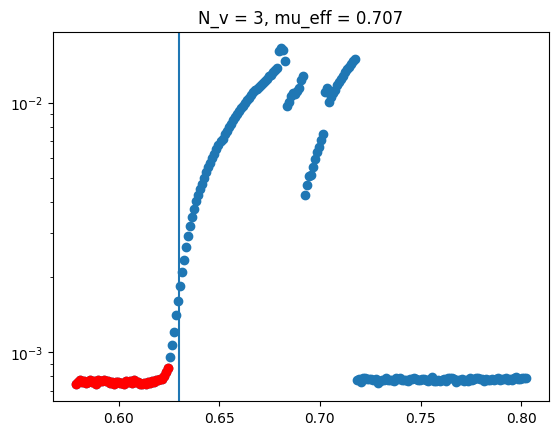

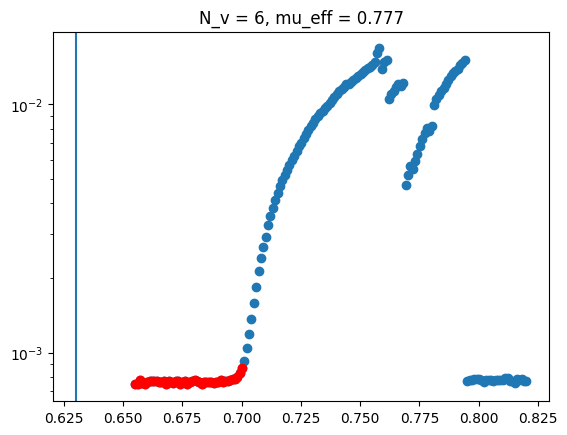

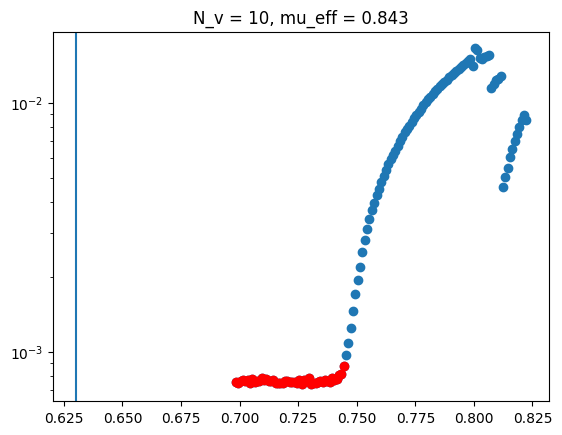

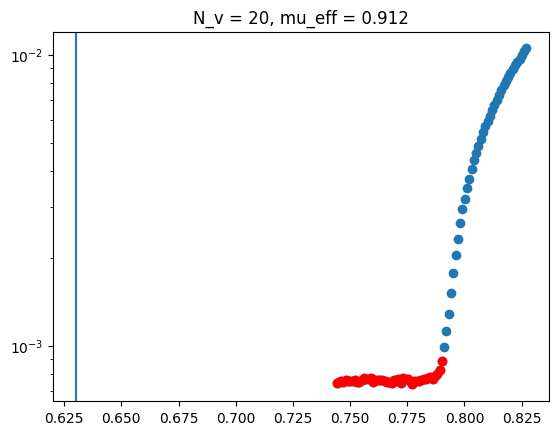

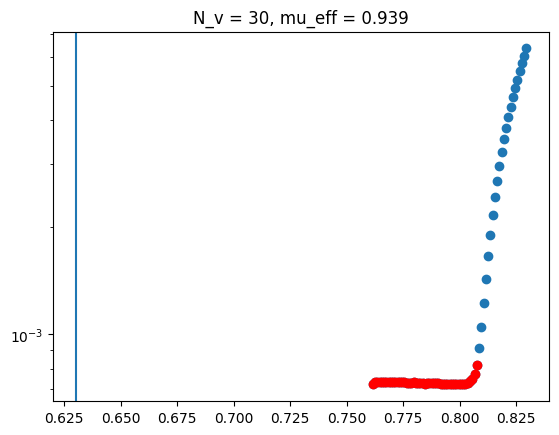

In [3]:
values = {}
trial_id = 0
while True:
    root = f'/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus-small-lower-temp-extra/trial-{trial_id}'
    if not os.path.exists(root):
        break
    trial_id += 1
    i = 0
    while True:
        path = os.path.join(root, f"overlap_{i}.npz")
        if not os.path.exists(path):
            break
        data = np.load(path)
        overlap = data['overlap']
        mu_eff = np.round(data['mu_eff'], 10)
        nv = data['nv']
        phi = np.round(data['packing_fraction'], 10)
        for j in range(overlap.shape[0]):
            mu = mu_eff[j]
            n = nv[j]
            max_phi = get_max_phi(overlap_df, mu, n, 2)
            if phi[j] >= max_phi:  # exclude data with overlaps
                continue
            if (mu, n) not in values:
                values[(mu, n)] = {}
            if phi[j] not in values[(mu, n)]:
                values[(mu, n)][phi[j]] = []
            values[(mu, n)][phi[j]].append(overlap[j])
        i += 1

overlap_cutoff = 1.2
show_plots = True
overlap_data = {}
for mu_n_key in values.keys():
    ov_data, phi_data = [], []
    for i, phi_key in enumerate(values[mu_n_key].keys()):
        ov_data.append(np.mean(np.array(values[mu_n_key][phi_key], dtype=object), axis=0))
        phi_data.append(phi_key)
    ov_data = np.array(ov_data).astype(float)
    phi_data = np.array(phi_data).astype(float)
    order = np.argsort(phi_data)
    phi_data = phi_data[order]
    ov_data = ov_data[order]
    mask = ov_data < np.mean(ov_data[:10]) * overlap_cutoff
    if show_plots:
        plt.scatter(phi_data, ov_data)
    if np.any(~mask):
        split_idx = np.argmax(ov_data)
        phi_data = phi_data[:split_idx]
        ov_data = ov_data[:split_idx]
        mask = ov_data < np.mean(ov_data[:10]) * overlap_cutoff
    ov_data = ov_data[mask]
    phi_data = phi_data[mask]
    if show_plots:
        plt.scatter(phi_data, ov_data, c='r')
        plt.yscale('log')
        plt.axvline(0.63)
        plt.title(f'N_v = {mu_n_key[1] - 1}, mu_eff = {mu_n_key[0]:.3f}')
        plt.show()
    overlap_data[mu_n_key] = {'ov': ov_data, 'phi': phi_data, 'max_phi': np.max(phi_data)}

In [ ]:
import pickle
with open('/home/mmccraw/dev/analysis/fall-25/09/run-compression/cutoff_mask.pkl', 'rb') as f:
    cutoff_mask = pickle.load(f)

values = {}
trial_id = 0
while True:
    # root = f'/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus-final/trial-{trial_id}'; dt = 1e-2; T = 1e-5
    # root = f'/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus/trial-{trial_id}'; dt = 1e2; T = 1e-5
    # root = f'/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus-small/trial-{trial_id}'; dt = 1e-2; T = 1e-5

    root = f'/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus-small-lower-temp/trial-{trial_id}'; dt = 2e-2; T = 1e-6
    # root = f'/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus-fine-range/trial-{trial_id}'; dt = 2e-2; T = 1e-6
    if not os.path.exists(root):
        break
    trial_id += 1
    i = 0
    while True:
        path = os.path.join(root, f"shear_modulus_{i}.npz")
        if not os.path.exists(path):
            break
        data = np.load(path)

        G = data['shear_modulus']
        t = data['t'] * dt * np.sqrt(T)
        mu_eff = np.round(data['mu_eff'], 10)
        nv = data['nv']
        phi = np.round(data['packing_fraction'], 10)

        for j in range(G.shape[1]):
            mu = mu_eff[j]
            n = nv[j]
            # max_phi = overlap_data[(mu, n)]['max_phi'] * 100
            max_phi = cutoff_mask[(mu, n)]
            # max_phi = np.inf
            if phi[j] >= max_phi - 0.01:  # exclude data with overlaps
                continue
            if (mu, n) not in values:
                values[(mu, n)] = {}
            if phi[j] not in values[(mu, n)]:
                values[(mu, n)][phi[j]] = []
            values[(mu, n)][phi[j]].append([G[:, j], t])
        i += 1

shear_modulus_data = {}
for mu_n_key in values.keys():
    g_data, t_data, phi_data = [], [], []
    for i, phi_key in enumerate(values[mu_n_key].keys()):
        g, t = np.mean(np.array(values[mu_n_key][phi_key], dtype=object), axis=0)
        g_data.append(g)
        t_data.append(t)
        phi_data.append(phi_key)
    g_data = np.array(g_data).astype(float)
    t_data = np.array(t_data).astype(float)
    phi_data = np.array(phi_data).astype(float)
    shear_modulus_data[mu_n_key] = {'g': g_data, 't': t_data, 'phi': phi_data}

In [5]:
# fit prony series
# test convergence to __spectra__ for varied number of terms in prony series using model data
# WE DONT WANT TO PLOT DATA THAT HAS OVERLAPS: use the overlaps-pe-pressure hp data to cut out packing fractions that have vertex overlaps > 10 * the average low,density data

In [7]:
cmap = plt.cm.viridis
for nv in nv_unique:
    for k in keys:
        if k[1] != 4:
            continue
        mu_eff = k[0]
        phi_norm = plt.Normalize(min(shear_modulus_data[k]['phi']), max(shear_modulus_data[k]['phi']))
        for g, t, phi in zip(shear_modulus_data[k]['g'], shear_modulus_data[k]['t'], shear_modulus_data[k]['phi']):
            plt.plot(t, g / g[0], c=cmap(phi_norm(phi)))
            # plt.plot(t, g, c=cmap(phi_norm(phi)))
        plt.xscale('log')
        plt.title(fr'$N_v$ = {k[1] - 1}, $\mu$ = {k[0]:.3f}')
        plt.show()
    break

NameError: name 'nv_unique' is not defined

/tmp/ipykernel_1521299/74199866.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(shear_modulus_data[k]['phi'], G_0, c=cmap(mu_eff_norm(mu_eff)), s=10)
/tmp/ipykernel_1521299/74199866.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(shear_modulus_data[k]['phi'], tau, c=cmap(mu_eff_norm(mu_eff)), s=10)


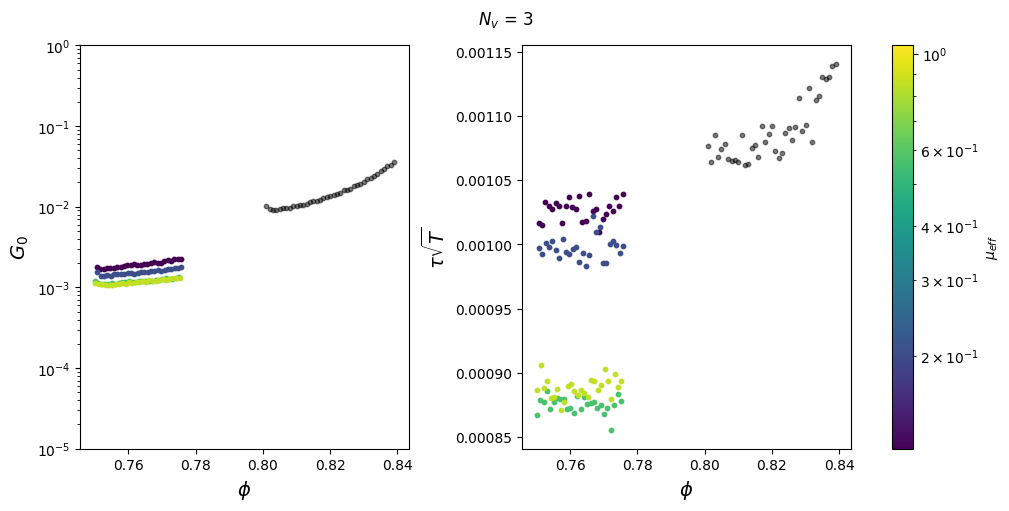

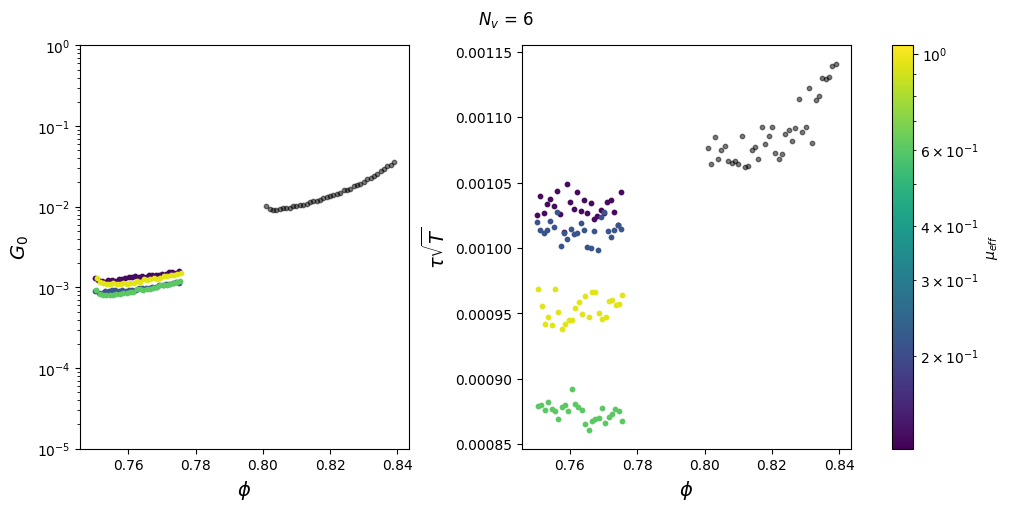

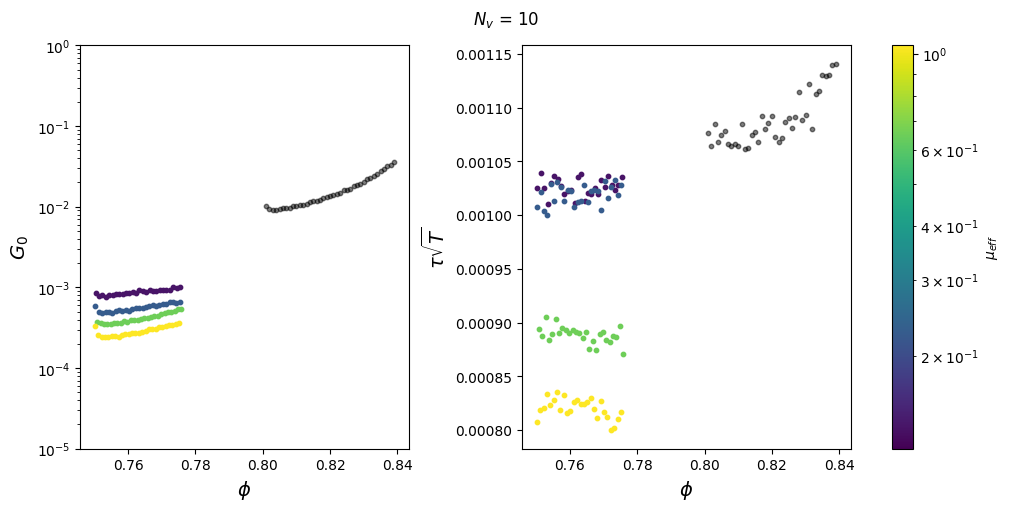

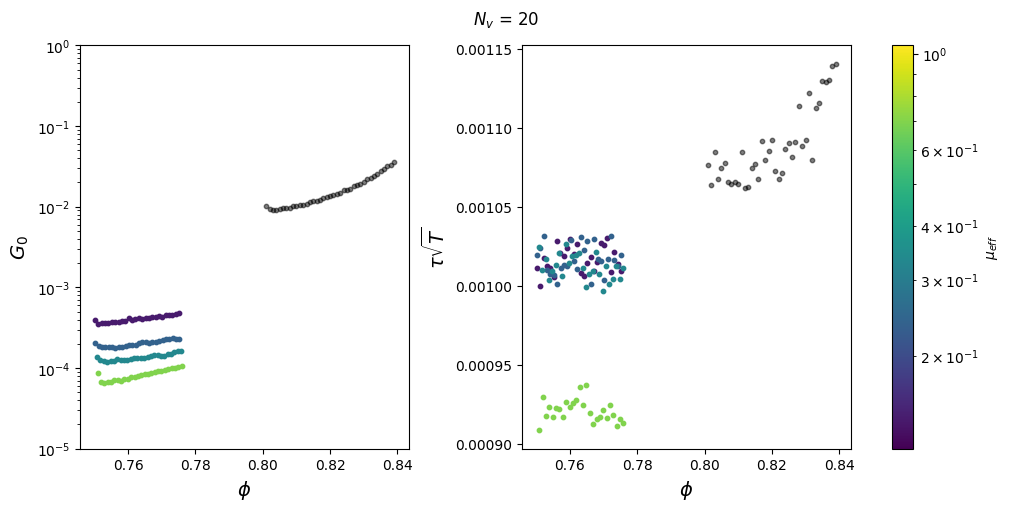

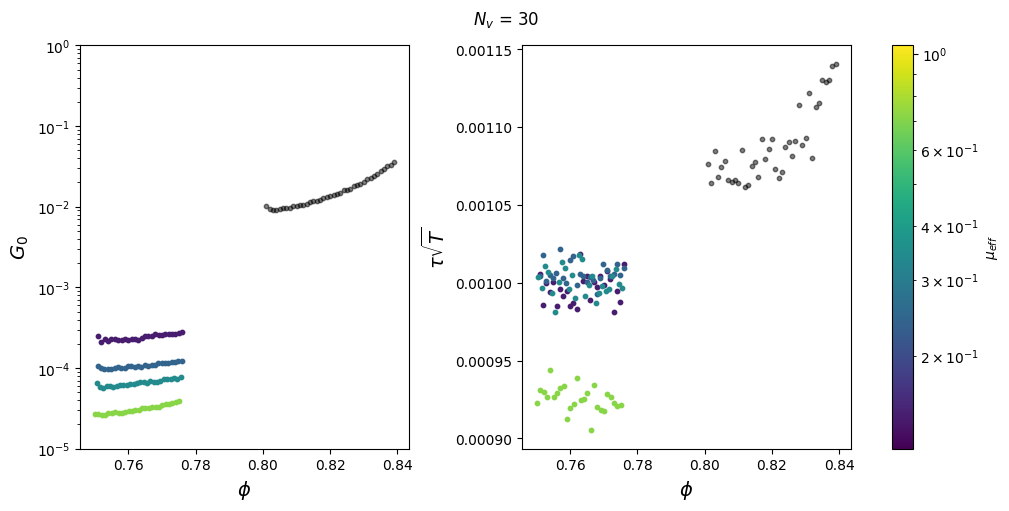

In [109]:
disk_df = pd.read_csv('/home/mmccraw/dev/analysis/fall-25/10/disk-shear-modulus/shear_modulus.csv')


keys = list(shear_modulus_data.keys())
mu_eff_unique = np.unique(np.array(keys)[:, 0])
nv_unique = np.unique(np.array(keys)[:, 1])
mu_eff_norm = LogNorm(min(mu_eff_unique), max(mu_eff_unique))
cmap = plt.cm.viridis
for nv in nv_unique:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

    ax[0].scatter(disk_df.phi, disk_df.G0, c='k', s=10, zorder=0, alpha=0.5)
    ax[1].scatter(disk_df.phi, disk_df.tau, c='k', s=10, zorder=0, alpha=0.5)

    for k in keys:
        if k[1] != nv:
            continue
        mu_eff = k[0]
        tau = [get_relaxation_time(g / g[0], t) for g, t in zip(shear_modulus_data[k]['g'], shear_modulus_data[k]['t'])]
        G_0 = [g[0] for g in shear_modulus_data[k]['g']]
        ax[0].scatter(shear_modulus_data[k]['phi'], G_0, c=cmap(mu_eff_norm(mu_eff)), s=10)
        ax[1].scatter(shear_modulus_data[k]['phi'], tau, c=cmap(mu_eff_norm(mu_eff)), s=10)
    for a in ax:
        # a.set_yscale('log')
        a.set_xlabel(r'$\phi$', fontsize=14)
    ax[0].set_yscale('log')
    ax[0].set_ylabel(r'$G_0$', fontsize=14)
    ax[1].set_ylabel(r'$\tau \sqrt{T}$', fontsize=14)
    ax[0].set_ylim(1e-5, 1e0)
    # ax[1].set_ylim(1e-4, 1e-2)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_unique)
    cbar = plt.colorbar(sm, ax=ax, label=r'$\mu_{eff}$')
    # plt.savefig(f'figures/G0_tau_NV_{nv - 1}.png', dpi=300)
    plt.show()



In [ ]:
# measure actual overlaps - cut out data using that
# measure angular velocity

In [98]:
p = '/home/mmccraw/dev/data/10-01-25/short-test-2/trial-0/dynamics_15'
data = load(p, location=['init', 'final'], load_trajectory=True, load_full=False)

In [99]:
data.packing_fraction

array([0.78948929, 0.73763942, 0.81419659, 0.85743509])

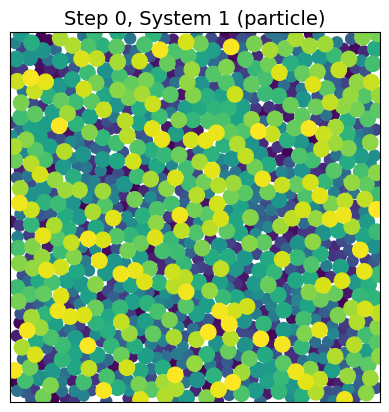

In [101]:
draw_particles_frame(0, plt.gca(), data, 1, True, 'particle', 'viridis', 'trajectory')

In [ ]:
from scipy.spatial import cKDTree
def nearest_neighbor_pairs(pos, box_size, rmax, unique_radius=None, radii=None):
    tree = cKDTree(np.mod(pos, box_size), boxsize=box_size)
    pairs = np.fromiter(tree.query_pairs(r=rmax), dtype=np.dtype([('i',np.int32),('j',np.int32)]))
    i = pairs['i']
    j = pairs['j']
    if unique_radius is not None:
        mask = (radii[i] == unique_radius) & (radii[j] == unique_radius)
        i = i[mask]
        j = j[mask]
    return i, j

@requires_fields('pos')
def neighbor_list_kernel(indices, get_frame, system_id, box_size, radii, rmax, r_bins=None):
    t0 = indices[0]
    pos_all = get_frame(t0)['pos']
    neighbor_list = []
    neighbor_size = []
    bin_ids = []
    for sid in np.unique(system_id):
        pos = pos_all[system_id == sid]
        bs = box_size[sid]
        r = radii[system_id == sid]
        unique_r = np.min(r)
        pairs_i, pairs_j = nearest_neighbor_pairs(pos, bs, rmax, unique_r, r)
        neighbor_list.append(np.column_stack([pairs_i, pairs_j]))
        neighbor_size.append(len(pairs_i))
        if r_bins is not None:
            dr = pos[pairs_i] - pos[pairs_j]
            dr -= np.round(dr / bs) * bs
            distances = np.linalg.norm(dr, axis=1)
            bin_ids.append(np.digitize(distances, r_bins) + sid * len(r_bins))
    if r_bins is not None:
        return np.concatenate(neighbor_list), np.concatenate([[0], np.cumsum(neighbor_size)]), np.concatenate(bin_ids)
    return np.concatenate(neighbor_list), np.concatenate([[0], np.cumsum(neighbor_size)])

def compute_neighbor_list_for_all_frames(data, rmax, r_bins=None, n_workers=10):
    bins = TimeBins.from_source(data.trajectory)
    res = run_binned_ragged(
        neighbor_list_kernel,
        data.trajectory, bins,
        kernel_kwargs={
            'system_id': data.system_id,
            'box_size': data.box_size,
            'radii': data.rad,
            'rmax': rmax,
            'r_bins': r_bins
        },
        show_progress=True,
        n_workers=n_workers
    )
    neighbor_list_by_frame = [_[0][0] for _ in res.results]
    neighbor_offset_by_frame = [_[0][1] for _ in res.results]
    if r_bins is not None:
        bin_ids_by_frame = [_[0][2] for _ in res.results]
        return neighbor_list_by_frame, neighbor_offset_by_frame, bin_ids_by_frame
    return neighbor_list_by_frame, neighbor_offset_by_frame


In [43]:
rmax = 3
n_bins = 20
r_bins = np.linspace(0.5, rmax, n_bins)
n_systems = data.n_systems()

neighbor_list_by_frame, neighbor_offset_by_frame, bin_ids_by_frame = compute_neighbor_list_for_all_frames(data, rmax, r_bins)

Ragged binned collection: 100%|██████████| 10000/10000 [01:01<00:00, 161.48it/s]


In [28]:
@requires_fields('angular_vel')
def simple_angle_kernel(indices, get_frame, system_size, system_offset, neighbor_list_by_frame, neighbor_offset_by_frame):
    t0, t1 = indices
    w1 = get_frame(t1)['angular_vel']
    neighbor_list = neighbor_list_by_frame[t0]
    neighbor_offset = neighbor_offset_by_frame[t0]
    num_neighbors = np.diff(neighbor_offset)
    # average the angular velocity products over ALL neighbors at the time origin
    numerator = np.add.reduceat(w1[neighbor_list[:, 0]] * w1[neighbor_list[:, 1]], neighbor_offset[:-1]) / num_neighbors
    denominator = np.add.reduceat(w1 ** 2, system_offset[:-1]) / system_size
    return numerator, denominator  # aggregate the numerator and denominator separately and then divide
@requires_fields('angular_vel')
def angle_kernel(indices, get_frame, system_size, system_offset, neighbor_list_by_frame, bin_ids_by_frame, n_bins, n_systems):
    t0, t1 = indices
    w1 = get_frame(t1)['angular_vel']
    # average the angular velocity products for neighbors (at the time origin) in each bin
    bin_ids = bin_ids_by_frame[t0]
    neighbor_list = neighbor_list_by_frame[t0]
    # sum products by bin_id
    products = w1[neighbor_list[:, 0]] * w1[neighbor_list[:, 1]]
    w_w_delta = np.bincount(bin_ids, weights=products, minlength=n_bins * n_systems).reshape(n_systems, n_bins)
    delta = np.bincount(bin_ids, minlength=n_bins * n_systems).reshape(n_systems, n_bins)
    return w_w_delta, delta
@requires_fields('angular_vel')
def angle_kernel_denominator(indices, get_frame, system_size, system_offset):
    t0, t1 = indices
    w1 = get_frame(t1)['angular_vel']
    return np.add.reduceat(w1 ** 2, system_offset[:-1]) / system_size

@requires_fields('angle')
def simple_angle_disp_kernel(indices, get_frame, system_size, system_offset, neighbor_list_by_frame, neighbor_offset_by_frame):
    t0, t1 = indices
    dtheta = get_frame(t1)['angle'] - get_frame(t0)['angle']
    neighbor_list = neighbor_list_by_frame[t0]
    neighbor_offset = neighbor_offset_by_frame[t0]
    num_neighbors = np.diff(neighbor_offset)
    # average the angular velocity products over ALL neighbors at the time origin
    numerator = np.add.reduceat(dtheta[neighbor_list[:, 0]] * dtheta[neighbor_list[:, 1]], neighbor_offset[:-1]) / num_neighbors
    denominator = np.add.reduceat(dtheta ** 2, system_offset[:-1]) / system_size
    return numerator, denominator  # aggregate the numerator and denominator separately and then divide
@requires_fields('angle')
def angle_disp_kernel(indices, get_frame, system_size, system_offset, neighbor_list_by_frame, bin_ids_by_frame, n_bins, n_systems):
    t0, t1 = indices
    dtheta = get_frame(t1)['angle'] - get_frame(t0)['angle']
    # average the angular velocity products for neighbors (at the time origin) in each bin
    bin_ids = bin_ids_by_frame[t0]
    neighbor_list = neighbor_list_by_frame[t0]
    # sum products by bin_id
    products = dtheta[neighbor_list[:, 0]] * dtheta[neighbor_list[:, 1]]
    w_w_delta = np.bincount(bin_ids, weights=products, minlength=n_bins * n_systems).reshape(n_systems, n_bins)
    delta = np.bincount(bin_ids, minlength=n_bins * n_systems).reshape(n_systems, n_bins)
    return w_w_delta, delta
@requires_fields('angle')
def angle_disp_kernel_denominator(indices, get_frame, system_size, system_offset):
    t0, t1 = indices
    dtheta = get_frame(t1)['angle'] - get_frame(t0)['angle']
    return np.add.reduceat(dtheta ** 2, system_offset[:-1]) / system_size

In [34]:
neighbor_list_by_frame[0]

array([ 86, 337], dtype=int32)

In [ ]:
bins = LagBinsPseudoLog.from_source(data.trajectory)

# res = run_binned(simple_angle_kernel, data.trajectory, bins, kernel_kwargs={'system_size': data.system_size, 'system_offset': data.system_offset, 'neighbor_list_by_frame': neighbor_list_by_frame, 'neighbor_offset_by_frame': neighbor_offset_by_frame}, show_progress=True, n_workers=10)

# res = run_binned(angle_kernel, data.trajectory, bins, kernel_kwargs={'system_size': data.system_size, 'system_offset': data.system_offset, 'neighbor_list_by_frame': neighbor_list_by_frame, 'bin_ids_by_frame': bin_ids_by_frame, 'n_bins': n_bins, 'n_systems': n_systems}, show_progress=True, n_workers=10)
# res_denominator = run_binned(angle_kernel_denominator, data.trajectory, bins, kernel_kwargs={'system_size': data.system_size, 'system_offset': data.system_offset}, show_progress=True, n_workers=10)

# res = run_binned(simple_angle_disp_kernel, data.trajectory, bins, kernel_kwargs={'system_size': data.system_size, 'system_offset': data.system_offset, 'neighbor_list_by_frame': neighbor_list_by_frame, 'neighbor_offset_by_frame': neighbor_offset_by_frame}, show_progress=True, n_workers=10)

res = run_binned(angle_disp_kernel, data.trajectory, bins, kernel_kwargs={'system_size': data.system_size, 'system_offset': data.system_offset, 'neighbor_list_by_frame': neighbor_list_by_frame, 'bin_ids_by_frame': bin_ids_by_frame, 'n_bins': n_bins, 'n_systems': n_systems}, show_progress=True, n_workers=10)
res_denominator = run_binned(angle_disp_kernel_denominator, data.trajectory, bins, kernel_kwargs={'system_size': data.system_size, 'system_offset': data.system_offset}, show_progress=True, n_workers=10)

Binned accumulation: 100%|██████████| 310005/310005 [00:07<00:00, 43503.28it/s] 


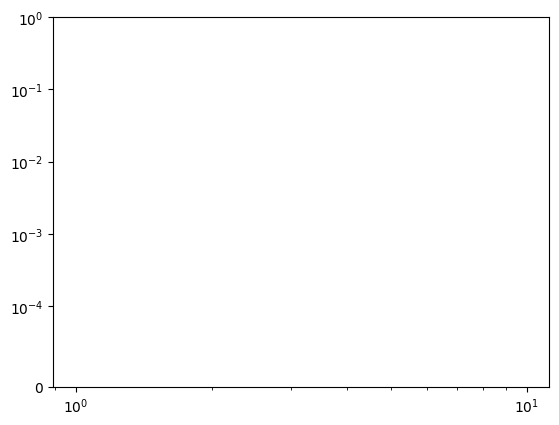

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pydpmd.data import load
root = '/home/mmccraw/dev/data/10-01-25/short-test-2/trial-0/'



# nv_target = 4
# mu_eff_target = 0.70710678

nv_target = 21
mu_eff_target = 0.91161379

phi_norm = plt.Normalize(vmin=0.7, vmax=0.85)
cmap = plt.cm.viridis

i = 0
# while os.path.exists(data_path := os.path.join(root, f'dynamics_{i}', 'angle_disp.npz')):
while os.path.exists(data_root := os.path.join(root, f'dynamics_{i}')):
    i += 1
    data_path = os.path.join(data_root, 'angle_disp.npz')
    # data_path = os.path.join(data_root, 'simple_angle_disp.npz')
    data = load(data_root, location=['final', 'init'])
    break
    data.calculate_mu_eff()
    if not os.path.exists(data_path):
        continue
    f = np.load(data_path)

    # print(data.n_vertices_per_particle[data.system_offset[:-1]])
    # print(data.mu_eff[data.system_offset[:-1]])

    sid = np.argwhere(np.isclose(data.mu_eff[data.system_offset[:-1]], mu_eff_target) & (data.n_vertices_per_particle[data.system_offset[:-1]] == nv_target))
    if len(sid) == 0:
        continue
    sid = sid[0][0]
    area = np.prod(data.box_size[sid])

    theta_theta_delta = f['angle_disp']
    theta_sq = f['denominator']
    r = f['r']
    t = f['t']
    theta_theta_delta[:, 0] /= theta_sq[..., None]
    S = theta_theta_delta[:, 0] / theta_theta_delta[:, 1]
    S[np.isnan(S)] = 0
    # plt.plot(r, S[20, sid], c=cmap(phi_norm(data.packing_fraction[sid])))

    r_i = r[np.argmax(S != 0, axis=2)]
    r_f = r_i * 1.2

    mask = (r[None, None, :] >= r_i[..., None]) & (r[None, None, :] <= r_f[..., None])

    S_t = np.sum(S * mask, axis=2) / np.sum(mask, axis=2)

    plt.plot(t, S_t[:, sid], c=cmap(phi_norm(data.packing_fraction[sid])))
plt.xscale('log')
# plt.xlim(1, 1e2)
plt.yscale('symlog', linthresh=1e-4)

    # S = (f['simple_angle_disp'][:, 0] / f['simple_angle_disp'][:, 1])[:, sid]
    # t = f['t']
    # plt.plot(t, S, c=cmap(phi_norm(data.packing_fraction[sid])))

In [3]:
g = f['angle_disp'][:, 1]
g_mean = np.mean(g, axis=0)[0]

dr = r[1] - r[0]
shell_area = np.pi * ((r + dr) ** 2 - r ** 2)
# n = np.sum(g_mean)
n = 400
norm = shell_area * (n * (n - 1)) / area

plt.plot(r, g_mean / norm)

    # shell_area = np.pi * (edges[1:]**2 - edges[:-1]**2)
    # norm = shell_area * (n * (n - 1)) / area



NameError: name 'f' is not defined

In [4]:
r_i = r[np.argmax(S != 0, axis=2)]
r_f = r_i * 1.5

mask = (r[None, None, :] >= r_i[..., None]) & (r[None, None, :] <= r_f[..., None])

S_t = np.sum(S * mask, axis=2) / np.sum(mask, axis=2)

plt.plot(t, S_t[:, 0])
plt.xscale('log')

NameError: name 'r' is not defined

In [ ]:
from correlation_functions import compute_neighbor_list_for_all_frames
rmax = 3
n_bins = 100
r_bins = np.linspace(0.5, rmax, n_bins)

data = load(data_root, location=['init', 'final'], load_trajectory=True, load_full=False)
data.calculate_mu_eff()
neighbor_list_by_frame, neighbor_offset_by_frame, bin_ids_by_frame = compute_neighbor_list_for_all_frames(data, rmax, r_bins)
n_systems = data.n_systems()

unique_radii = np.unique(data.rad)
radii = data.rad

dr = r_bins[1] - r_bins[0]
shell_area = np.pi * ((r_bins + dr) ** 2 - r_bins ** 2)
area = np.prod(data.box_size, axis=1)

normalizations = []
for target_rad in unique_radii:
    n = np.add.reduceat(radii == target_rad, data.system_offset[:-1])
    normalizations.append((shell_area[None, :] * (n * (n - 1) / (2 * area))[:, None]))

Ragged binned collection:   0%|          | 0/10000 [00:00<?, ?it/s]

Ragged binned collection: 100%|██████████| 10000/10000 [01:16<00:00, 130.94it/s]


In [5]:

# dtheta = get_frame(t1)['angle'] - get_frame(t0)['angle']
t1 = 10
t0 = 0

dtheta = data.trajectory[t1].angle - data.trajectory[t0].angle
# average the angular velocity products for neighbors (at the time origin) in each bin
bin_ids = bin_ids_by_frame[t0]
neighbor_list = neighbor_list_by_frame[t0]
neighbor_offset = neighbor_offset_by_frame[t0]
neighbor_size = neighbor_offset[1:] - neighbor_offset[:-1]
# sum products by bin_id
products = dtheta[neighbor_list[:, 0]] * dtheta[neighbor_list[:, 1]]

for target_rad, norm in zip(unique_radii, normalizations):
    # only get neighbors with equal size radii
    neighbor_mask = (radii[neighbor_list[:, 0]] == target_rad) & (radii[neighbor_list[:, 1]] == target_rad)

    w_w_delta = np.bincount(bin_ids[neighbor_mask], products[neighbor_mask], minlength=n_bins * n_systems).reshape(n_systems, n_bins)

    delta = np.bincount(bin_ids[neighbor_mask], minlength=n_bins * n_systems).reshape(n_systems, n_bins)
    g = delta / norm

    



TypeError: 'NoneType' object is not subscriptable

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pydpmd.data import load
import numpy as np
from pydpmd.data import load
import os
from numba import njit
from scipy.spatial import cKDTree
from pydpmd.calc import run_binned, run_binned_ragged, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields


@requires_fields('angle')
def angle_disp_kernel(indices, get_frame, neighbor_list_by_frame, bin_ids_by_frame, n_bins, n_systems):
    t0, t1 = indices
    dtheta = get_frame(t1)['angle'] - get_frame(t0)['angle']
    # average the angular velocity products for neighbors (at the time origin) in each bin
    bin_ids = bin_ids_by_frame[t0]
    neighbor_list = neighbor_list_by_frame[t0]
    # sum products by bin_id
    products = dtheta[neighbor_list[:, 0]] * dtheta[neighbor_list[:, 1]]
    # only get neighbors with equal size radii
    w_w_delta = np.bincount(bin_ids, products, minlength=n_bins * n_systems).reshape(n_systems, n_bins)
    delta = np.bincount(bin_ids, minlength=n_bins * n_systems).reshape(n_systems, n_bins)
    return w_w_delta, delta

In [97]:

root = '/home/mmccraw/dev/data/10-01-25/short-test-3/trial-0/'

data = load(os.path.join(root, 'dynamics_20'), location=['final', 'init'], load_trajectory=True, load_full=False)


from correlation_functions import compute_neighbor_list_for_all_frames, simple_angle_disp_kernel, angle_disp_kernel, angle_disp_kernel_denominator, compute_pair_correlation_function
from pydpmd.calc import run_binned, LagBinsPseudoLog

rmax = 3
n_bins = 1000
r_bins = np.linspace(0.5, rmax, n_bins)
g, r = compute_pair_correlation_function(data, r_bins)


# dr = r_bins[1] - r_bins[0]
# shell_area = np.pi * ((r_bins + dr) ** 2 - r_bins ** 2)
# area = np.prod(data.box_size, axis=1)

unique_radii = np.unique(data.rad)
radii = data.rad

n_workers = 10

bins = LagBinsPseudoLog.from_source(data.trajectory)

for i, target_rad in enumerate(unique_radii):
    break

for sid in np.unique(data.system_id):
    break

sid = 0

first_shell_factor = 1.0
n_bins_first_shell = 100

r_bins_first_shell = np.linspace(0.5, r_bins[np.argmax(g[sid, i])] * first_shell_factor, n_bins_first_shell)
neighbor_list_by_frame, neighbor_offset_by_frame, bin_ids_by_frame = compute_neighbor_list_for_all_frames(data, np.max(r_bins_first_shell), r_bins_first_shell, target_rad=target_rad, sid=sid, n_workers=n_workers)
n_systems = data.n_systems()

Ragged binned collection: 100%|██████████| 100000/100000 [00:01<00:00, 72818.64it/s]


In [98]:
# radial distribution normalization factor
n = np.add.reduceat(radii == target_rad, data.system_offset[:-1])
normalization = (shell_area[None, :] * (n * (n - 1) / (2 * area))[:, None])

res = run_binned(angle_disp_kernel, data.trajectory, bins, kernel_kwargs={'neighbor_list_by_frame': neighbor_list_by_frame, 'bin_ids_by_frame': bin_ids_by_frame, 'n_bins': n_bins_first_shell, 'n_systems': n_systems}, show_progress=True, n_workers=n_workers)
res_denominator = run_binned(angle_disp_kernel_denominator, data.trajectory, bins, kernel_kwargs={'system_size': data.system_size, 'system_offset': data.system_offset}, show_progress=True, n_workers=n_workers)

Binned accumulation: 100%|██████████| 3999946/3999946 [00:04<00:00, 836818.31it/s] 


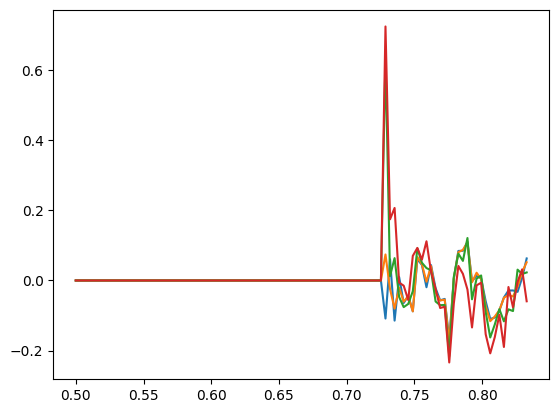

In [99]:
theta_theta_delta = res.mean[:, 0].copy()
g = np.mean(res.mean[:, 1].copy(), axis=0)
nonzero_mask = g > 0
theta_theta_delta[:, nonzero_mask] /= g[nonzero_mask]
S = theta_theta_delta / res_denominator.mean[..., None]

plt.plot(r_bins_first_shell, (S[0, sid]))
plt.plot(r_bins_first_shell, (S[15, sid]))
plt.plot(r_bins_first_shell, (S[20, sid]))
plt.plot(r_bins_first_shell, (S[25, sid]))

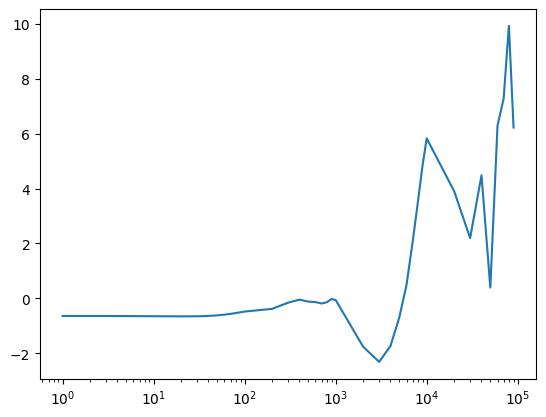

In [100]:
plt.plot(bins.values(), np.sum(S, axis=2)[:, sid])
plt.xscale('log')

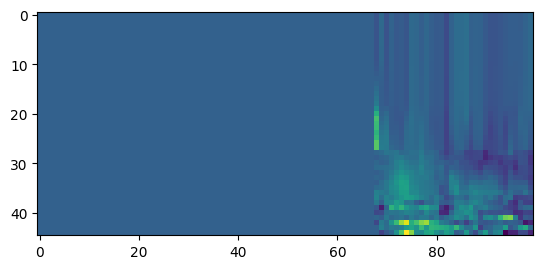

In [101]:
plt.imshow(S[:, sid])

In [51]:
r_i = r_bins[np.argmax(S != 0, axis=2)]
r_f = r_i * 1.001

mask = (r_bins[None, None, :] >= r_i[..., None]) & (r_bins[None, None, :] <= r_f[..., None])

S_t = np.sum(S * mask, axis=2) / np.sum(mask, axis=2)

plt.plot(bins.values(), S_t[:, sid])
plt.xscale('log')

ValueError: operands could not be broadcast together with shapes (36,2,100) (36,2,1000) 

/tmp/ipykernel_384714/207101167.py:20: RuntimeWarning: invalid value encountered in divide
  A = a[:, 0] / a[:, 1]


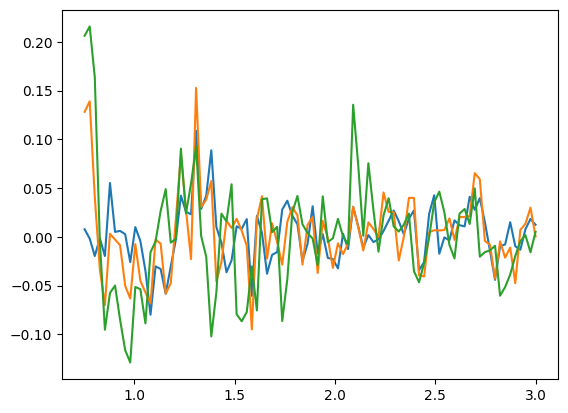

In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
root = '/home/mmccraw/dev/data/10-01-25/short-test-2/trial-0/'
# root = '/home/mmccraw/dev/data/10-01-25/short-test-3/trial-0/'

for path in os.listdir(root):
    if not path.startswith('dynamics_'):
        continue
    if 'simple_angle_disp.npz' in os.listdir(os.path.join(root, path)):
        break

a = np.load(os.path.join(root, path, 'angle_disp.npz'))['angle_disp']
b = np.load(os.path.join(root, path, 'angle_disp.npz'))['denominator']
r = np.load(os.path.join(root, path, 'angle_disp.npz'))['r']
t = np.load(os.path.join(root, path, 'angle_disp.npz'))['t']
# MAY HAVE TO INCORPORATE THE g(r) NORMALIZATION!

a[:, 0] /= b[..., None]
A = a[:, 0] / a[:, 1]

sid = 0

plt.plot(r, A[0, sid])
plt.plot(r, A[20, sid])
plt.plot(r, A[-10, sid])

# a = np.load(os.path.join(root, path, 'simple_angle_disp.npz'))['simple_angle_disp']
# t = np.load(os.path.join(root, path, 'simple_angle_disp.npz'))['t']
# a = a[:, 0] / a[:, 1]
# plt.plot(t, a[:, 0])
# plt.plot(t, a[:, 1])
# plt.plot(t, a[:, 2])
# plt.plot(t, a[:, 3])
# plt.plot(t, a[:, 4])
# plt.yscale('log')
# plt.xscale('log')


In [5]:
np.load(os.path.join(root, path, 'angle_disp.npz'))['mu_eff']

array([0.39223227, 0.42107871, 0.44652885, 0.70710678, 0.77709425,
       0.84330743])

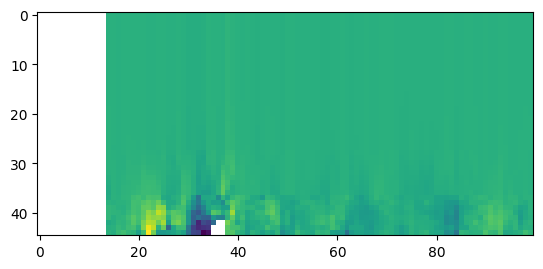

In [41]:
plt.imshow(A[:, 4])

/tmp/ipykernel_2858829/2770272308.py:1: RuntimeWarning: invalid value encountered in divide
  S = ((res.mean[:, 0] / res.mean[:, 1]) / res_denominator.mean[..., None])


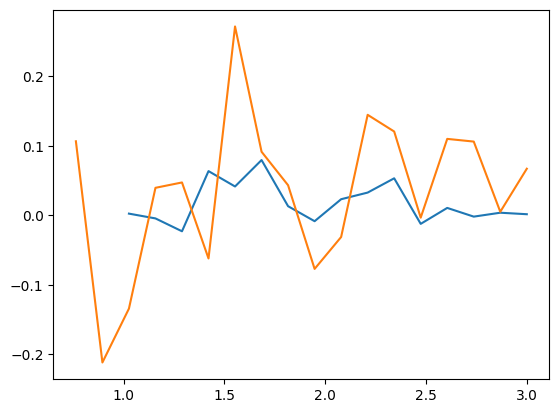

In [88]:
S = ((res.mean[:, 0] / res.mean[:, 1]) / res_denominator.mean[..., None])
plt.plot(r_bins, S[0, 0])
plt.plot(r_bins, S[-1, 20])

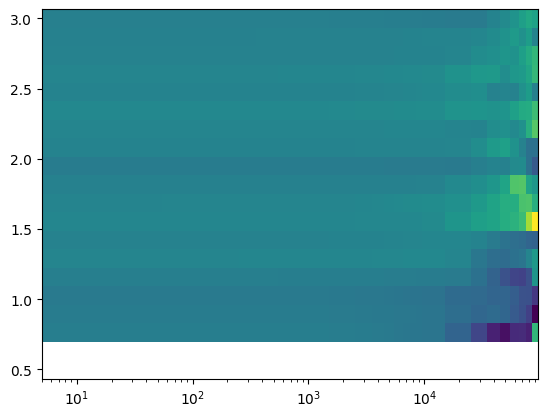

In [89]:
im = plt.pcolormesh(bins.values(), r_bins, S[:, 20].T, shading='auto', cmap='viridis')
plt.xscale('log')

In [90]:
S = res.mean[:, 0] / res.mean[:, 1]

/tmp/ipykernel_2858829/479060538.py:1: RuntimeWarning: invalid value encountered in divide
  S = res.mean[:, 0] / res.mean[:, 1]


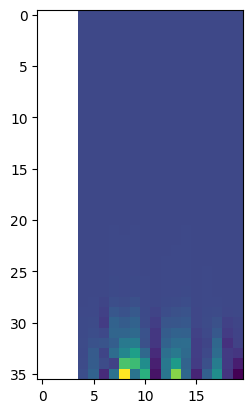

In [91]:
plt.imshow(S[:, 0])

/tmp/ipykernel_1285303/2218203746.py:1: RuntimeWarning: invalid value encountered in divide
  S = res.mean[:, 0] / res.mean[:, 1]


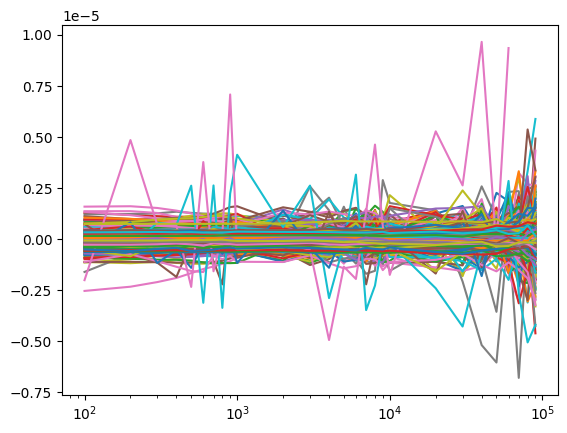

In [225]:
S = res.mean[:, 0] / res.mean[:, 1]
plt.plot(bins.values(), S[:, 0])
plt.plot(bins.values(), S[:, 1])
plt.plot(bins.values(), S[:, 2])
plt.plot(bins.values(), S[:, 3])
plt.xscale('log')

ValueError: x and y can be no greater than 2D, but have shapes (27,) and (27, 4, 100)

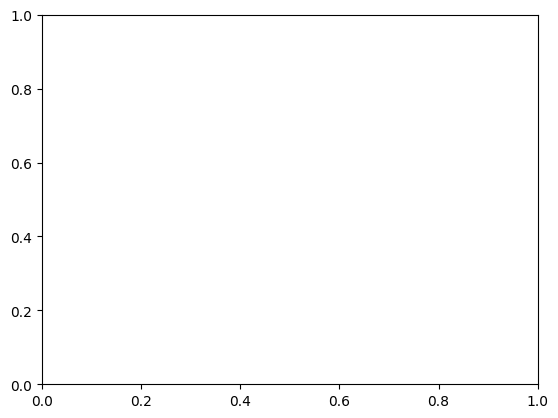

In [216]:
plt.plot(bins.values(), res.mean[:, 0])
plt.plot(bins.values(), res.mean[:, 1])
plt.plot(bins.values(), res.mean[:, 2])
plt.plot(bins.values(), res.mean[:, 3])
plt.xscale('log')

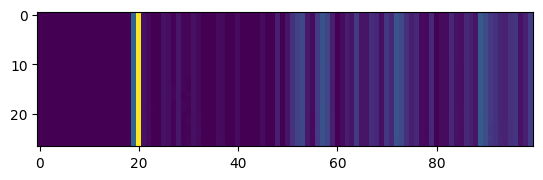

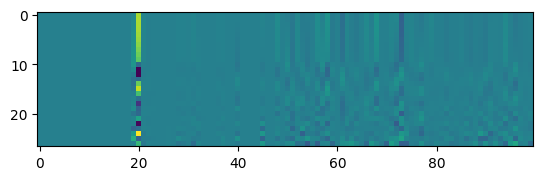

In [177]:
sid = 0
plt.imshow(res.mean[:, 1, sid])
plt.show()
plt.imshow(res.mean[:, 0, sid])
plt.show()

/tmp/ipykernel_1285303/2944554652.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow((res.mean[:, 0] / res.mean[:, 1])[:, 0])


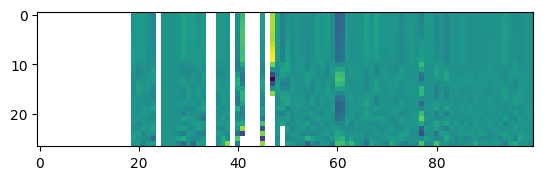

In [140]:
plt.imshow((res.mean[:, 0] / res.mean[:, 1])[:, 0])

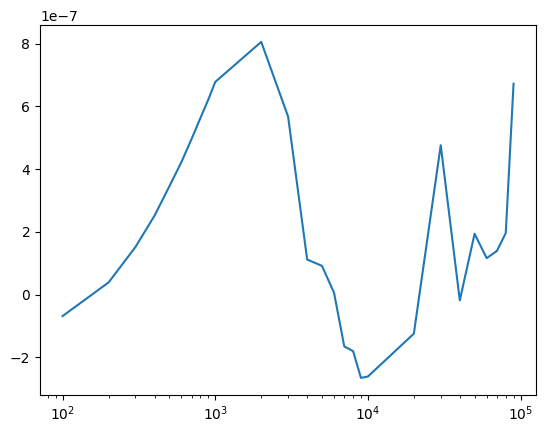

In [170]:

plt.plot(bins.values(), np.mean(res.mean[:, 0, 20, (r_bins > 0.4) & (r_bins < 0.8)], axis=-1))
plt.xscale('log')

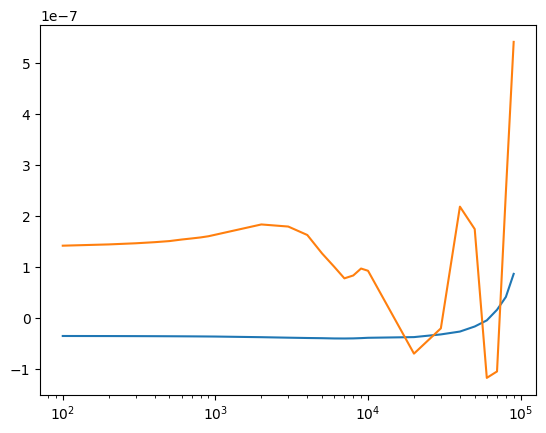

In [52]:
plt.plot(bins.values(), res.mean[:, 0])
plt.plot(bins.values(), res.mean[:, 20])
plt.xscale('log')


In [34]:
name = 'dynamics_40'
data = load(f'/home/mmccraw/dev/data/10-01-25/short-test/trial-0/{name}',
location=['init', 'final'], load_trajectory=True, load_full=True)
print(data.packing_fraction[24])

Loading trajectory: 100%|██████████| 4/4 [00:00<00:00, 14.90it/s]

0.8016060433569249


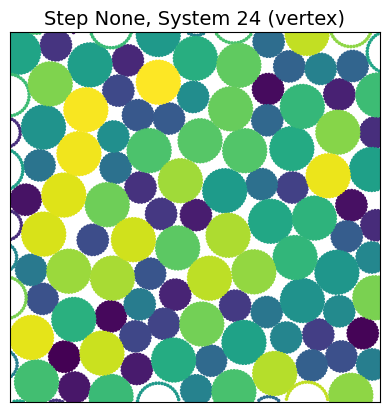

In [33]:
draw_particles_frame(None, plt.gca(), data, 24, True, 'vertex', 'viridis', None)

In [35]:
desired_frames = 100
steps_to_animate = downsample(data, desired_frames)

# Define the output path
output_path = f"animations-new/{name}.gif"

# Create the animation using the downsampled steps
create_animation(
    update_func=draw_particles_frame,
    frames=steps_to_animate,
    filename=output_path,
    fps=15,  # 15 fps for smooth but not too fast animation
    dpi=150,  # Higher resolution
    bitrate=3000,  # Higher bitrate for better quality
    # Keyword arguments passed to draw_particles_frame
    data=data,
    system_id=24,
    use_pbc=True,
    which='vertex',
    cmap_name='viridis'
)

Creating animation:   0%|          | 0/100 [00:00<?, ?it/s]

Saving animation to animations-new/dynamics_40.gif...


Creating animation: 101it [01:17,  1.30it/s]                         

Animation saved successfully!
